## FreqPulse-VAE: A Frequency-Conditioned Variational Autoencoder for Pulsatile Signal Generation

In [1]:
import os
import numpy as np
import pandas as pd
import yaml
from tqdm import trange, tqdm
from functools import reduce
from scipy import stats
import itertools

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, GRU, Dense, Masking, Reshape, Flatten, RepeatVector, TimeDistributed, Bidirectional, Activation, GaussianNoise, Lambda, LSTM
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from Models.MainModel import *
from Utilities.Utilities import *
from Utilities.EvaluationModules import *
from Models.Losses import *

import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

def read_yaml(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)

#### Env setting

In [8]:
ConfigName = 'SKZFC_ART_50_800'


if 'ART' in ConfigName:
    LoadConfig = 'Config' + 'ART'
elif 'PLETH' in ConfigName:
    LoadConfig = 'Config' + 'PLETH'
elif 'II' in ConfigName:
    LoadConfig = 'Config' + 'II'
else:
    assert False, "Please verify if the data type is properly included in the name of the configuration. The configuration name should be structured as 'Config' + 'data type', such as ConfigART."

yaml_path = './Config/'+LoadConfig+'.yml'

SavePath = './Results/'
ConfigSet = read_yaml(yaml_path)

### Model related parameters
SigType = ConfigSet[ConfigName]['SigType']
LatDim = ConfigSet[ConfigName]['LatDim']
CompSize = ConfigSet[ConfigName]['CompSize']

MaskingRate = ConfigSet[ConfigName]['MaskingRate']
NoiseStd = ConfigSet[ConfigName]['NoiseStd']
MaskStd = ConfigSet[ConfigName]['MaskStd']
ReparaStd = ConfigSet[ConfigName]['ReparaStd']
FcLimit = ConfigSet[ConfigName]['FcLimit']
DecayH = ConfigSet[ConfigName]['DecayH']
DecayL = ConfigSet[ConfigName]['DecayL']
ReparaStd = 10
BatchSize = 10000

ModelName = ConfigName+'.hdf5'
### Model checkpoint
ModelSaveName = SavePath+ModelName


### Data

In [3]:
TrData = np.load('./Data/ProcessedData/Tr'+str(SigType)+'.npy')
ValData = np.load('./Data/ProcessedData/Val'+str(SigType)+'.npy')

SigDim = ValData.shape[1]
DataSize = ValData.shape[0]

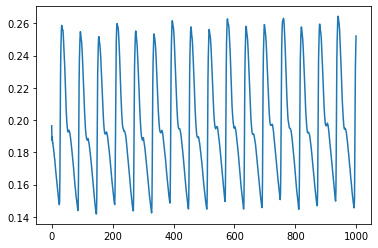

In [4]:
plt.plot(ValData[9])

In [19]:
TMP = FFT_PS(ValData, 'PSD', MinFreq = 1, MaxFreq = 51)


AxisError: axis 2 is out of bounds for array of dimension 2

### Post model

In [5]:
# Defining Modesl
EncModel = Encoder(SigDim=SigDim, LatDim= LatDim, Type = '', MaskingRate = MaskingRate, NoiseStd = NoiseStd, MaskStd = MaskStd, ReparaStd = ReparaStd, Reparam=True, FcLimit=FcLimit)
FeatExtModel = FeatExtractor(SigDim=SigDim, CompSize = CompSize, DecayH=DecayH, DecayL=DecayL)
FeatGenModel = FeatGenerator(SigDim=SigDim,FeatDim=FeatExtModel.output[1].shape[-1], LatDim= LatDim)
ReconModel = Reconstructor(SigDim=SigDim, FeatDim=FeatExtModel.output[1].shape[-1])

Models = [EncModel,FeatExtModel,FeatGenModel,ReconModel] 

# Adding losses
SigRepModel = TCLosses(Models, DataSize, ConfigSet[ConfigName])


### Load weights
SigRepModel.load_weights(ModelSaveName)

### Regularizer resetting
for i in SigRepModel.weights:
    if i.name.split('/')[0] in ['Beta_Z','Beta_Fc','Beta_TC', 'Beta_MI' ,'Beta_Orig', 'Beta_Feat']:
        i.assign(1.)
        
## Model Compile
SigRepModel.compile(optimizer='adam') 
SigRepModel.summary()

## The model for evaluation
RecOut = ReconModel(FeatGenModel.output)
GenModel = Model(FeatGenModel.input, RecOut)

OrigRecLoss added
FeatRecLoss added
kl_Loss_SKZ selected
kl_Loss_Z added
kl_Loss_FC added
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inp_Enc (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
tf.signal.frame (TFOpLambda)    (None, 20, 50)       0           Inp_Enc[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 20, 50)       11550       tf.signal.frame[0][0]            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 20, 50)       11550       bidirectional[0][0]              
____

In [6]:
def FFT_PS(Data, Metric, MinFreq = 1, MaxFreq = 51):
    # Power Spectral Density
    HalfLen = Data.shape[-1]//2
    FFTRes = np.abs(np.fft.fft(Data, axis=-1)[..., :HalfLen])[..., MinFreq:MaxFreq]
    PSD = (FFTRes**2)/FFTRes.shape[-1]
    
    # Probability Density Function
    PSPDF = PSD / np.sum(PSD, axis=(1, 2),keepdims=True)
    
    # Power Spectral Entropy
    PSE = -np.sum(PSPDF * np.log(PSPDF), axis=-1)
    # Probability Density Function for Power Spectral Entropy
    PSEPDF = PSE / np.sum(PSE, axis=(-1),keepdims=True)
    
    
    if 'PSD' in Metric:
        Value = PSD
    elif 'PSPDF' in Metric:
        Value = PSPDF
        
    # The 0 frequency is excluded as it represents the constant term; by adding 1 to the index, the frequency and index can be aligned to be the same.
    Max_Value_Label = np.argmax(Value, axis=-1) + 1
    ### Calculating mode values of MaxV_NG_ZFc; To index the max frequency, 1 is subtracted from the modes.
    Mode_Value = stats.mode(Max_Value_Label.T, axis=0, keepdims=False)[0] - 1
    ### (NMiniBat, Frequency_idx, NGen)
    TransValue = np.transpose(Value, (0, 2,1))
    #### Selecting variance values by the order of NMiniBat and Frequency_idx
    Max_Value = TransValue[np.arange(NMiniBat), Mode_Value]
    
    
    if 'PSD' == Metric:
        # (NMiniBat, NGen, NFreq)
        return PSD
    elif 'PSPDF'  == Metric:
        # (NMiniBat, NGen, NFreq)
        return PSPDF
    elif 'PSE'  == Metric:
        # (NMiniBat, NFreq)
        return PSE
    elif 'PSEPDF' == Metric:
        # (NMiniBat, NFreq)
        return PSEPDF
    elif 'Max_PSD' == Metric:
        # (NMiniBat, NFreq)
        return Max_Value
    elif 'Max_PSPDF' == Metric:
        # (NMiniBat, NFreq)
        return Max_Value
    
    
def ProbPermutation(Data, Nframe=3, EpsProb = 1e-7):
    
    # Generate true permutation cases
    TruePerms = np.concatenate(list(itertools.permutations(np.arange(Nframe)))).reshape(-1, Nframe)

    # Get all permutation cases
    Data_Ext = tf.signal.frame(Data, frame_length=Nframe, frame_step=1, axis=-1)
    PermsTable =  np.argsort(Data_Ext, axis=-1)

    CountPerms = 1- (TruePerms[None,None] == PermsTable[:,:,None])
    CountPerms = 1-np.sum(CountPerms, axis=-1).astype('bool')
    CountPerms = np.sum(CountPerms, axis=(1))
    ProbCountPerms = CountPerms / np.sum(CountPerms, axis=-1, keepdims=True)
    
    return np.maximum(ProbCountPerms, EpsProb)    



def ProbFreq (Data, NMiniBat, NGen, Axis, MeanZj=None, Metric ='PSD', MinFreq = 1, MaxFreq = 51, EpsProb = 1e-7):

    ### Conducting FFT 
    # Power Spectral Density
    PSD = FFT_PS(Data, Metric=Metric, MinFreq = MinFreq, MaxFreq = MaxFreq)

    ### Max PSD label
    MaxPSDLabel = np.argmax(PSD, axis=-1) + 1
    MaxVLabelIDX =  np.arange(MaxFreq - MinFreq) + 1

    if Axis =='All':
        # The 0 frequency is excluded as it represents the constant term; by adding 1 to the index, the frequency and index can be aligned to be the same.
        MaxVLabelCount = np.zeros_like(MaxVLabelIDX)
        MaxV, Count = np.unique(MaxPSDLabel, return_counts=True)
        MaxVLabelCount[MaxV] = Count

        ### Probability of frequencies 
        Prob = MaxVLabelCount / np.sum(MaxVLabelCount)

    elif Axis =='One':
        MaxVLabelCount = []
        MaxV_MeanZj = []
        # Mini batch-wise max freqeuncy count
        for num, mini in enumerate(MaxPSDLabel):
            
            if MeanZj is not None: # To identify at which z-value the maximum of a particular frequency is often formed.
                MeanZj = MeanZj.reshape(NMiniBat, NGen, -1)
                MaxV_MeanZj.append(np.mean(MeanZj[num], axis=0)[None]) 
                
            Count_ = np.zeros_like(MaxVLabelIDX)
            MaxV, Count = np.unique(mini, return_counts=True)
            Count_[MaxV] = Count
            MaxVLabelCount.append(Count_[None])

        # (Batch_size, N_frequency)
        MaxVLabelCount = np.concatenate(MaxVLabelCount)    
        Prob = MaxVLabelCount / NGen 
    
    if MeanZj is not None:
        return np.maximum(Prob, EpsProb), np.concatenate(MaxV_MeanZj)    
    else:
        return np.maximum(Prob, EpsProb)
    
    
def Sampler (Data):
    #Z_Mu_Out = SigRepModel.get_layer('Z_Mu').output
    Zs_Out = SigRepModel.get_layer('Zs').output
    #Z_Sigma_Out = SigRepModel.get_layer('Z_Log_Sigma').output
    #FCs_Out = SigRepModel.get_layer('FCs').output
    Sampler = Model(EncModel.input, Zs_Out)
    return Sampler.predict(Data, batch_size=BatchSize, verbose=1)   

In [7]:
MaxFreq = 51
MinFreq = 1
NMiniBat = 500
SimSize = 1
MinFreqR=0.
MaxFreqR=0.05
NGen = 100
Ndata = len(ValData)
MASize = Ndata//NMiniBat
AnalData = ValData
NFCs = SigRepModel.get_layer('FCs').output.shape[-1]
NSelZ = 1
FCmuEps = 0.05

In [43]:
FC_Arange_ = np.tile(np.linspace(MinFreqR, MaxFreqR, NGen )[:, None], (1,NFCs))
 

### monte carlo approximation
I_V_Z = 0
I_V_ZjZ = 0
I_V_Zj = 0
I_V_FRZj = 0
I_V_FAZj = 0
I_VE_FMZj = 0
I_VE_FAZj = 0

for sim in range(SimSize):
    
    SplitData = np.array_split(AnalData, MASize)
    with trange(MASize, leave=False) as t:

        for mini in range(MASize):
            #print(sim, mini, MASize)
          
            print('Sampling Samp_Zs and Samp_Fc')
            # Sampling
            SplitData_Ext =  np.broadcast_to(SplitData[mini][:, None], (NMiniBat, NGen, SplitData[mini].shape[-1])).reshape(-1, SplitData[mini].shape[-1])
            Samp_Z = Sampler(SplitData_Ext)
            FCs = np.random.rand(NMiniBat *NGen, NFCs) * FcLimit
            
            print('Setting SigGen_ZFc')
            # Reconstruction; y ~ Q(Y | Z, Fc)Q(Z, Fc | Y)
            
            print('Setting SigGen_ZjFc')
            # Masking for selecting Samp_Zj from Samp_Z by assuming Zs with indices other than j have mean values '0' of Guassian dist.
            Mask_Z = np.zeros((NMiniBat*NGen, LatDim))
            for i in range(NMiniBat*NGen):
                Mask_Z[i, np.random.choice(LatDim, NSelZ,replace=False )] = 1
            Samp_Zj = Samp_Z * Mask_Z
            
            
            print('Setting SigGen_ZjFcRPT')            
            # Selecting Samp_Zj from Guassian dist by assuming Zs with indices other than j have mean values '0' of Guassian dist and repeat the values NGen times.
            Samp_ZjRPT = []
            for i in range(NMiniBat):
                Mask_Z = np.zeros((LatDim))
                # LatDim-wise Z sampling
                Mask_Z[ np.random.choice(LatDim, NSelZ,replace=False )]= np.random.normal(0, ReparaStd)
                # Setting the same Z value within the N generated signals (NGen).
                Samp_ZjRPT.append(np.broadcast_to(Mask_Z[None], (NGen,LatDim))[None]) 
            Samp_ZjRPT = np.concatenate(Samp_ZjRPT).reshape(NMiniBat *NGen, LatDim)
            
            
            print('Setting SigGen_ZjFcAr')
            # Reconstruction; y ~ P(Y | Fc, Zj)Q(Zj); 
            # The Fc values on FC_Arange (FcAr) are generated based on the linspace with a fixed interval.
            FC_Arange = np.broadcast_to(FC_Arange_[None], (NMiniBat, NGen, NFCs)).reshape(-1, NFCs)
            
            
            print('Setting SigGen_ZjFcMu')
            # Reconstruction; y ~ P(Y | Zj, Fc)Q(Z)Q(j)Q(Fc); j~U() Fc~U() and Z~N(0, std) 
            # Assuming all FC_μ x FcLimit + eps, FC_μ=0.5, eps ~ N(0, 0.5*FcLimit*FCmuEps)
            Rand_FCs = np.zeros_like(FCs) + FcLimit * 0.5 + np.random.normal(0, (FcLimit * 0.5)*FCmuEps, (FCs.shape))
            
            # Signal generation
            Set_FCs = np.concatenate([FCs,FCs,FCs,FC_Arange,Rand_FCs])
            Set_Zs = np.concatenate([Samp_Z,Samp_Zj,Samp_ZjRPT,Samp_ZjRPT,Samp_ZjRPT])
            Set_Pred = GenModel.predict([Set_FCs[:, :2], Set_FCs[:, 2:], Set_Zs], batch_size=BatchSize, verbose=1).reshape(-1, NMiniBat, NGen, Set_Pred.shape[-1])
            SigGen_ZFc, SigGen_ZjFc, SigGen_ZjFcRPT, SigGen_ZjFcAr, SigGen_ZjFcMu = [np.squeeze(SubPred) for SubPred in np.split(Set_Pred, 5) ]  
                             
                
            # Max frequency wise values
            Q_V = ProbFreq (SigGen_ZFc, NMiniBat, NGen, 'All', Metric='PSD',  MinFreq = 1, MaxFreq = 51)
            Q_V_Z = ProbFreq (SigGen_ZFc, NMiniBat, NGen, 'One', Metric='PSD', MinFreq = 1, MaxFreq = 51)
            Q_V_Zj = ProbFreq (SigGen_ZjFc, NMiniBat, NGen,'One', Metric='PSD', MinFreq = 1, MaxFreq = 51)
            Q_V_Zj_FR = ProbFreq (SigGen_ZjFcRPT, NMiniBat, NGen,'One', Metric='PSD', MinFreq = 1, MaxFreq = 51)
            Q_V_Zj_FA = ProbFreq (SigGen_ZjFcAr, NMiniBat, NGen,'One', Metric='PSD', MinFreq = 1, MaxFreq = 51)
            #Q_V_Zj_FA, MaxV_MeanZj = ProbFreq (SigGen_ZjFcAr, NMiniBat, NGen,'One', MeanZj=Samp_Zj, Metric='PSD', MinFreq = 1, MaxFreq = 51)
            
         
            
            # Max frequency entropy-wise values
            MaxPSD_ZjFcRPT = FFT_PS(SigGen_ZjFcRPT, 'Max_PSD', MinFreq = 1, MaxFreq = 51)
            MaxPSD_ZjFcMu = FFT_PS(SigGen_ZjFcMu, 'Max_PSD', MinFreq = 1, MaxFreq = 51)
            MaxPSD_ZjFcAr = FFT_PS(SigGen_ZjFcAr, 'Max_PSD', MinFreq = 1, MaxFreq = 51)

            
            # Calculate the permutation entropy based on the PSD values of the frequency with the max PSD from generated signals.
            Q_VE = ProbPermutation(MaxPSD_ZjFcRPT, Nframe=3)
            Q_VE_Zj_FM = ProbPermutation(MaxPSD_ZjFcMu, Nframe=3)
            Q_VE_Zj_FA = ProbPermutation(MaxPSD_ZjFcAr, Nframe=3)


            
            # I(V;Z)
            I_V_Z_ = np.mean(np.sum(Q_V_Z * np.log(Q_V_Z / Q_V[None]), axis=-1))
            print('I_V_Z : ', I_V_Z_)
            I_V_Z += I_V_Z_
            
            # I(V;Zj|Z)
            I_V_ZjZ_ = np.mean(np.sum(Q_V_Zj * np.log(Q_V_Zj / Q_V_Z), axis=-1))
            print('I_V_ZjZ : ', I_V_ZjZ_)
            I_V_ZjZ += I_V_ZjZ_
            
            
            
            # I(V;Zj)
            I_V_FRZj_ = np.mean(np.sum(Q_V_Zj_FR * np.log(Q_V_Zj_FR / Q_V), axis=-1))
            print('I_V_FRZj : ', I_V_FRZj_)
            I_V_FRZj += I_V_FRZj_
            
            # I(V;FC|Zj)
            I_V_FAZj_ = np.mean(np.sum(Q_V_Zj_FA * np.log(Q_V_Zj_FA / Q_V_Zj_FR), axis=-1))
            print('I_V_FAZj : ', I_V_FAZj_)
            I_V_FAZj += I_V_FAZj_
            
            
            
            # I(VE;Zj)
            I_VE_FMZj_ = np.mean(np.sum(Q_VE_Zj_FM * np.log(Q_VE_Zj_FM / Q_VE), axis=-1))
            print('I_VE_FMZj : ', I_VE_FMZj_)
            I_VE_FMZj += I_VE_FMZj_
            
            # I(VE;FC|Zj)
            I_VE_FAZj_ = np.mean(np.sum(Q_VE_Zj_FA * np.log(Q_VE_Zj_FA / Q_VE_Zj_FM), axis=-1))
            print('I_VE_FAZj : ', I_VE_FAZj_)
            I_VE_FAZj += I_VE_FAZj_
            
            
            t.update(1)


# CMI(V;Zj, Z)
I_V_Z /= (MASize*SimSize)
I_V_ZjZ /= (MASize*SimSize)
CMI_V_ZjZ = I_V_Z + I_V_ZjZ             

# CMI(V;FC,Zj)
I_V_FRZj /= (MASize*SimSize)
I_V_FAZj /= (MASize*SimSize)
CMI_V_FCZj = I_V_FRZj + I_V_FAZj             

# CMI(VE;FA,FM)
I_VE_FMZj /= (MASize*SimSize)
I_VE_FAZj /= (MASize*SimSize)
CMI_VE_FAFM = I_VE_FMZj + I_VE_FAZj             


  0%|                                                                                          | 0/120 [00:00<?, ?it/s]

Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 34ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 118ms/step


  1%|▋                                                                                 | 1/120 [00:13<26:39, 13.44s/it]

I_V_Z :  0.11817946024232732
I_V_ZjZ :  1.2968319072146883
I_V_FRZj :  2.6065616865553873
I_V_FAZj :  0.22560578587808866
I_VE_FMZj :  0.03375876820202041
I_VE_FAZj :  0.825479473371547
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 49ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 120ms/step


  2%|█▎                                                                                | 2/120 [00:26<26:25, 13.43s/it]

I_V_Z :  0.11756551568600278
I_V_ZjZ :  1.309285917450361
I_V_FRZj :  2.6071316692784423
I_V_FAZj :  0.22605084416331545
I_VE_FMZj :  0.03457826103847647
I_VE_FAZj :  0.8025235000128411
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 48ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 118ms/step


  2%|██                                                                                | 3/120 [00:41<26:58, 13.83s/it]

I_V_Z :  0.11892446758008768
I_V_ZjZ :  1.3287984455989952
I_V_FRZj :  2.5569375119361504
I_V_FAZj :  0.2156204028703085
I_VE_FMZj :  0.039040038517802925
I_VE_FAZj :  0.8136318857246387
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 61ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 120ms/step


  3%|██▋                                                                               | 4/120 [00:54<26:31, 13.72s/it]

I_V_Z :  0.12116947313551378
I_V_ZjZ :  1.3670164349612037
I_V_FRZj :  2.630431576090694
I_V_FAZj :  0.21473610372337823
I_VE_FMZj :  0.03448279632805152
I_VE_FAZj :  0.8057735875210638
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 37ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 122ms/step


  4%|███▍                                                                              | 5/120 [01:08<26:07, 13.63s/it]

I_V_Z :  0.11970886776478272
I_V_ZjZ :  1.2904971979637332
I_V_FRZj :  2.588191129714256
I_V_FAZj :  0.19222155281285505
I_VE_FMZj :  0.03477237814062248
I_VE_FAZj :  0.8196344197113234
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 56ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 120ms/step


  5%|████                                                                              | 6/120 [01:22<26:21, 13.88s/it]

I_V_Z :  0.1202562415424718
I_V_ZjZ :  1.2751348543796512
I_V_FRZj :  2.609561048098536
I_V_FAZj :  0.2002619301901031
I_VE_FMZj :  0.03610876666538525
I_VE_FAZj :  0.8272573196835494
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 41ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 106ms/step


  6%|████▊                                                                             | 7/120 [01:35<25:38, 13.61s/it]

I_V_Z :  0.12097465583028974
I_V_ZjZ :  1.3170481013779047
I_V_FRZj :  2.5677752157978895
I_V_FAZj :  0.22998255790887542
I_VE_FMZj :  0.03876706892949906
I_VE_FAZj :  0.8230349169518213
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 63ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 120ms/step


  7%|█████▍                                                                            | 8/120 [01:49<25:47, 13.82s/it]

I_V_Z :  0.12057312856311361
I_V_ZjZ :  1.3278141442960614
I_V_FRZj :  2.6158873847805406
I_V_FAZj :  0.24700641994655106
I_VE_FMZj :  0.03570591462746744
I_VE_FAZj :  0.8097044789764656
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 50ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 125ms/step


  8%|██████▏                                                                           | 9/120 [02:03<25:25, 13.74s/it]

I_V_Z :  0.11836501116590088
I_V_ZjZ :  1.3395537547544256
I_V_FRZj :  2.6210764407650577
I_V_FAZj :  0.21801844711279378
I_VE_FMZj :  0.03639538011075221
I_VE_FAZj :  0.8027439181978684
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 58ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 120ms/step


  8%|██████▊                                                                          | 10/120 [02:16<25:02, 13.66s/it]

I_V_Z :  0.1179742615075785
I_V_ZjZ :  1.2865646436530052
I_V_FRZj :  2.562537172061111
I_V_FAZj :  0.2152675639969669
I_VE_FMZj :  0.03411370810313286
I_VE_FAZj :  0.795502458066016
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 53ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 117ms/step


  9%|███████▍                                                                         | 11/120 [02:31<25:07, 13.83s/it]

I_V_Z :  0.11880459177603088
I_V_ZjZ :  1.2854401454322804
I_V_FRZj :  2.579939845996524
I_V_FAZj :  0.22429162064363628
I_VE_FMZj :  0.03524291482596079
I_VE_FAZj :  0.8080310521631668
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 35ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 120ms/step


 10%|████████                                                                         | 12/120 [02:44<24:40, 13.71s/it]

I_V_Z :  0.12026050142658568
I_V_ZjZ :  1.287938538891152
I_V_FRZj :  2.5268965424849466
I_V_FAZj :  0.23116583566800725
I_VE_FMZj :  0.035732501782068285
I_VE_FAZj :  0.8090360820388804
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 69ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 120ms/step


 11%|████████▊                                                                        | 13/120 [02:58<24:20, 13.65s/it]

I_V_Z :  0.1154783563734724
I_V_ZjZ :  1.2870369896497298
I_V_FRZj :  2.6078629898760566
I_V_FAZj :  0.25125908685973997
I_VE_FMZj :  0.03644447518725103
I_VE_FAZj :  0.8124276743575604
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 64ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 108ms/step


 12%|█████████▍                                                                       | 14/120 [03:12<24:21, 13.78s/it]

I_V_Z :  0.11989441997536084
I_V_ZjZ :  1.2976509134344079
I_V_FRZj :  2.6271142054259613
I_V_FAZj :  0.26005644075401807
I_VE_FMZj :  0.0366715226678001
I_VE_FAZj :  0.8178846084547258
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 62ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 121ms/step


 12%|██████████▏                                                                      | 15/120 [03:25<23:57, 13.69s/it]

I_V_Z :  0.11759773469855239
I_V_ZjZ :  1.2801388802739038
I_V_FRZj :  2.629023294509205
I_V_FAZj :  0.22026984741650082
I_VE_FMZj :  0.03462347254237426
I_VE_FAZj :  0.8020827143356285
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 49ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 122ms/step


 13%|██████████▊                                                                      | 16/120 [03:39<23:37, 13.63s/it]

I_V_Z :  0.1194678668361029
I_V_ZjZ :  1.2999645266932256
I_V_FRZj :  2.5705840861161207
I_V_FAZj :  0.22589814760660437
I_VE_FMZj :  0.03624852684692152
I_VE_FAZj :  0.8163576029010842
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 50ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 117ms/step


 14%|███████████▍                                                                     | 17/120 [03:53<23:42, 13.81s/it]

I_V_Z :  0.12051545628558835
I_V_ZjZ :  1.3004372033193246
I_V_FRZj :  2.6437398785630806
I_V_FAZj :  0.19715665066356938
I_VE_FMZj :  0.03856698343706966
I_VE_FAZj :  0.8292508298646136
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 58ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 123ms/step


 15%|████████████▏                                                                    | 18/120 [04:06<23:20, 13.73s/it]

I_V_Z :  0.1200265050686128
I_V_ZjZ :  1.2913850314846305
I_V_FRZj :  2.5370343288983093
I_V_FAZj :  0.21351948187227282
I_VE_FMZj :  0.034940543219000746
I_VE_FAZj :  0.822282639321681
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 33ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 122ms/step


 16%|████████████▊                                                                    | 19/120 [04:21<23:22, 13.88s/it]

I_V_Z :  0.12168686537884817
I_V_ZjZ :  1.3502370585336319
I_V_FRZj :  2.6364805060913192
I_V_FAZj :  0.23405119263587684
I_VE_FMZj :  0.03686087892137137
I_VE_FAZj :  0.8080045862974586
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 51ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 108ms/step


 17%|█████████████▌                                                                   | 20/120 [04:34<22:48, 13.69s/it]

I_V_Z :  0.11856116767153131
I_V_ZjZ :  1.2938057784657424
I_V_FRZj :  2.6508051492725353
I_V_FAZj :  0.2204999816471763
I_VE_FMZj :  0.034562372344571456
I_VE_FAZj :  0.8157873424777067
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 42ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 112ms/step


 18%|██████████████▏                                                                  | 21/120 [04:47<22:22, 13.56s/it]

I_V_Z :  0.12009984623469463
I_V_ZjZ :  1.2825530271971117
I_V_FRZj :  2.604622503172142
I_V_FAZj :  0.2096307272077335
I_VE_FMZj :  0.03492938045951762
I_VE_FAZj :  0.8228861018081408
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 65ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 119ms/step


 18%|██████████████▊                                                                  | 22/120 [05:02<22:47, 13.96s/it]

I_V_Z :  0.12015200841644864
I_V_ZjZ :  1.3379376274124253
I_V_FRZj :  2.6025646174182366
I_V_FAZj :  0.23500582587125576
I_VE_FMZj :  0.035538864350532856
I_VE_FAZj :  0.7973953329097646
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 49ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 116ms/step


 19%|███████████████▌                                                                 | 23/120 [05:16<22:35, 13.97s/it]

I_V_Z :  0.11761302873204953
I_V_ZjZ :  1.277749291979213
I_V_FRZj :  2.638845715617316
I_V_FAZj :  0.23249586972023384
I_VE_FMZj :  0.03411396777231245
I_VE_FAZj :  0.8276239722932871
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 53ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 117ms/step


 20%|████████████████▏                                                                | 24/120 [05:30<22:21, 13.98s/it]

I_V_Z :  0.120739852318516
I_V_ZjZ :  1.320047512044435
I_V_FRZj :  2.6698008834633935
I_V_FAZj :  0.25559444001526394
I_VE_FMZj :  0.03589785747970069
I_VE_FAZj :  0.7985775913781168
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 37ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 120ms/step


 21%|████████████████▉                                                                | 25/120 [05:45<22:32, 14.24s/it]

I_V_Z :  0.1192893800066818
I_V_ZjZ :  1.3229847908052133
I_V_FRZj :  2.688253596321817
I_V_FAZj :  0.21032979262476256
I_VE_FMZj :  0.035459499843363884
I_VE_FAZj :  0.8098712642028042
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 49ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 115ms/step


 22%|█████████████████▌                                                               | 26/120 [05:59<22:07, 14.12s/it]

I_V_Z :  0.1165198916128955
I_V_ZjZ :  1.295311732431715
I_V_FRZj :  2.5839278498595095
I_V_FAZj :  0.23419522078940208
I_VE_FMZj :  0.03379443770830045
I_VE_FAZj :  0.8184156522638236
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 64ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 120ms/step


 22%|██████████████████▏                                                              | 27/120 [06:14<22:17, 14.38s/it]

I_V_Z :  0.1180407203139646
I_V_ZjZ :  1.3202970543294714
I_V_FRZj :  2.6149499348308995
I_V_FAZj :  0.20830731951935041
I_VE_FMZj :  0.035567192429693105
I_VE_FAZj :  0.8092336435461196
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 37ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 121ms/step


 23%|██████████████████▉                                                              | 28/120 [06:28<21:51, 14.26s/it]

I_V_Z :  0.1192434923089303
I_V_ZjZ :  1.3448512631838772
I_V_FRZj :  2.670132846468431
I_V_FAZj :  0.22627333683686954
I_VE_FMZj :  0.03509152580235921
I_VE_FAZj :  0.8158815957021281
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 67ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 121ms/step


 24%|███████████████████▌                                                             | 29/120 [06:42<21:34, 14.22s/it]

I_V_Z :  0.12060914608148213
I_V_ZjZ :  1.3209663758182846
I_V_FRZj :  2.6229550443588128
I_V_FAZj :  0.2548002257934329
I_VE_FMZj :  0.034244373437020685
I_VE_FAZj :  0.8038078208219221
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 36ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 123ms/step


 25%|████████████████████▎                                                            | 30/120 [06:57<21:39, 14.43s/it]

I_V_Z :  0.11839548639186653
I_V_ZjZ :  1.2501029002704465
I_V_FRZj :  2.5783207135799677
I_V_FAZj :  0.2147611642661741
I_VE_FMZj :  0.03696514859739156
I_VE_FAZj :  0.8250549691022295
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 53ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 121ms/step


 26%|████████████████████▉                                                            | 31/120 [07:11<21:16, 14.34s/it]

I_V_Z :  0.12154197631873077
I_V_ZjZ :  1.339524997297585
I_V_FRZj :  2.5620866199928023
I_V_FAZj :  0.24034508816074945
I_VE_FMZj :  0.033604834879433214
I_VE_FAZj :  0.8012058643029754
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 38ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 120ms/step


 27%|█████████████████████▌                                                           | 32/120 [07:25<20:54, 14.25s/it]

I_V_Z :  0.11913000320658415
I_V_ZjZ :  1.3346630580345193
I_V_FRZj :  2.6140077520916183
I_V_FAZj :  0.22527985601953152
I_VE_FMZj :  0.03540928076525098
I_VE_FAZj :  0.8157432951206132
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 61ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 119ms/step


 28%|██████████████████████▎                                                          | 33/120 [07:40<20:58, 14.47s/it]

I_V_Z :  0.12093266449589879
I_V_ZjZ :  1.360624082573925
I_V_FRZj :  2.595938488642635
I_V_FAZj :  0.21608456823475872
I_VE_FMZj :  0.033866180894779885
I_VE_FAZj :  0.7916219079592297
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 70ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 104ms/step


 28%|██████████████████████▉                                                          | 34/120 [07:54<20:25, 14.25s/it]

I_V_Z :  0.11737882430002518
I_V_ZjZ :  1.3348318146155371
I_V_FRZj :  2.602997307931244
I_V_FAZj :  0.20964820953100166
I_VE_FMZj :  0.03581608001117281
I_VE_FAZj :  0.8118068290353586
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 40ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 119ms/step


 29%|███████████████████████▋                                                         | 35/120 [08:08<20:23, 14.40s/it]

I_V_Z :  0.11855334078176752
I_V_ZjZ :  1.2823000509516755
I_V_FRZj :  2.6467826067493894
I_V_FAZj :  0.1998721439990577
I_VE_FMZj :  0.038202642044879054
I_VE_FAZj :  0.8402979746790429
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 52ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 123ms/step


 30%|████████████████████████▎                                                        | 36/120 [08:22<20:00, 14.29s/it]

I_V_Z :  0.12079560435120884
I_V_ZjZ :  1.2888918696992384
I_V_FRZj :  2.6328283624952378
I_V_FAZj :  0.22837711915200617
I_VE_FMZj :  0.03602087400359812
I_VE_FAZj :  0.803828232772217
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 45ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 122ms/step


 31%|████████████████████████▉                                                        | 37/120 [08:37<19:42, 14.24s/it]

I_V_Z :  0.11857988893574165
I_V_ZjZ :  1.3321375815315646
I_V_FRZj :  2.6008229253205175
I_V_FAZj :  0.22138502580300634
I_VE_FMZj :  0.03576647087450144
I_VE_FAZj :  0.7984669922020008
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 38ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 115ms/step


 32%|█████████████████████████▋                                                       | 38/120 [08:51<19:40, 14.39s/it]

I_V_Z :  0.12006505982086912
I_V_ZjZ :  1.30603769771533
I_V_FRZj :  2.640914007381506
I_V_FAZj :  0.2235432619668826
I_VE_FMZj :  0.03648266311842835
I_VE_FAZj :  0.8133718321234603
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 36ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 119ms/step


 32%|██████████████████████████▎                                                      | 39/120 [09:05<19:15, 14.26s/it]

I_V_Z :  0.11930172382887042
I_V_ZjZ :  1.2995850763440688
I_V_FRZj :  2.5677638285333493
I_V_FAZj :  0.2269019359103414
I_VE_FMZj :  0.0377895592251908
I_VE_FAZj :  0.8055459561850719
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 43ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 124ms/step


 33%|███████████████████████████                                                      | 40/120 [09:19<18:57, 14.22s/it]

I_V_Z :  0.12101148857137921
I_V_ZjZ :  1.3658571182503807
I_V_FRZj :  2.6847844017367413
I_V_FAZj :  0.22170794305485844
I_VE_FMZj :  0.035395344698249294
I_VE_FAZj :  0.8285619898490921
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 35ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 118ms/step


 34%|███████████████████████████▋                                                     | 41/120 [09:34<18:56, 14.39s/it]

I_V_Z :  0.11972926900971763
I_V_ZjZ :  1.289991194872072
I_V_FRZj :  2.6562027363996012
I_V_FAZj :  0.24860528500795215
I_VE_FMZj :  0.03548642320225817
I_VE_FAZj :  0.8027763215594789
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 50ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 121ms/step


 35%|████████████████████████████▎                                                    | 42/120 [09:48<18:34, 14.28s/it]

I_V_Z :  0.12008647879960653
I_V_ZjZ :  1.3777631523831833
I_V_FRZj :  2.568489873605794
I_V_FAZj :  0.24613165726193248
I_VE_FMZj :  0.03513266033379648
I_VE_FAZj :  0.8266314838035608
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 50ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 121ms/step


 36%|█████████████████████████████                                                    | 43/120 [10:03<18:34, 14.47s/it]

I_V_Z :  0.11932287077913238
I_V_ZjZ :  1.2876576457835704
I_V_FRZj :  2.6100979542376166
I_V_FAZj :  0.21491791410119102
I_VE_FMZj :  0.03470751292057342
I_VE_FAZj :  0.8176964054795444
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 50ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 120ms/step


 37%|█████████████████████████████▋                                                   | 44/120 [10:17<18:13, 14.39s/it]

I_V_Z :  0.1174889727764062
I_V_ZjZ :  1.3164904281963155
I_V_FRZj :  2.6284123674588553
I_V_FAZj :  0.23023720065717115
I_VE_FMZj :  0.03604407751618269
I_VE_FAZj :  0.7978643876161907
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 69ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 115ms/step


 38%|██████████████████████████████▍                                                  | 45/120 [10:31<17:50, 14.28s/it]

I_V_Z :  0.12076110821674627
I_V_ZjZ :  1.3420583293966655
I_V_FRZj :  2.571720090068601
I_V_FAZj :  0.2163911632649453
I_VE_FMZj :  0.03437870069420702
I_VE_FAZj :  0.8070825161647834
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 47ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 114ms/step


 38%|███████████████████████████████                                                  | 46/120 [10:46<17:47, 14.42s/it]

I_V_Z :  0.11820770587714263
I_V_ZjZ :  1.2828004576003496
I_V_FRZj :  2.603247306981466
I_V_FAZj :  0.23195361769783487
I_VE_FMZj :  0.03508039943761782
I_VE_FAZj :  0.8133288056699901
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 50ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 2s 93ms/step


 39%|███████████████████████████████▋                                                 | 47/120 [10:59<17:01, 14.00s/it]

I_V_Z :  0.11896651218727401
I_V_ZjZ :  1.3148375811222668
I_V_FRZj :  2.5867027437916166
I_V_FAZj :  0.2587967960228843
I_VE_FMZj :  0.03596897246383748
I_VE_FAZj :  0.8024297668227084
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 64ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 122ms/step


 40%|████████████████████████████████▍                                                | 48/120 [11:13<16:39, 13.88s/it]

I_V_Z :  0.11997323474135824
I_V_ZjZ :  1.3832783635819323
I_V_FRZj :  2.639792997266906
I_V_FAZj :  0.22338638004960787
I_VE_FMZj :  0.03887133166681906
I_VE_FAZj :  0.8130247711324375
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 49ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 121ms/step


 41%|█████████████████████████████████                                                | 49/120 [11:27<16:36, 14.03s/it]

I_V_Z :  0.11827320259784373
I_V_ZjZ :  1.3011999572347885
I_V_FRZj :  2.610994962930784
I_V_FAZj :  0.2432373560315098
I_VE_FMZj :  0.03454399619373238
I_VE_FAZj :  0.852336930687901
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 64ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 115ms/step


 42%|█████████████████████████████████▊                                               | 50/120 [11:40<16:08, 13.84s/it]

I_V_Z :  0.11852021404144938
I_V_ZjZ :  1.3124471045268482
I_V_FRZj :  2.520499578391274
I_V_FAZj :  0.2272057429757355
I_VE_FMZj :  0.036632907061461085
I_VE_FAZj :  0.7992910154249129
Sampling Samp_Zs and Samp_Fc


KeyboardInterrupt: 